Using device: cuda
Training with data size: 5000
Early stopping at epoch 380 due to reaching memorization accuracy of 95.10%
Memorization Accuracy for data size 5000: 95.10%
Training with data size: 7000
Early stopping at epoch 288 due to reaching memorization accuracy of 95.60%
Memorization Accuracy for data size 7000: 95.60%
Training with data size: 8000
Early stopping at epoch 266 due to reaching memorization accuracy of 95.83%
Memorization Accuracy for data size 8000: 95.83%
Training with data size: 9000
Early stopping at epoch 250 due to reaching memorization accuracy of 95.24%
Memorization Accuracy for data size 9000: 95.24%
Training with data size: 10000
Early stopping at epoch 241 due to reaching memorization accuracy of 95.13%
Memorization Accuracy for data size 10000: 95.13%
Training with data size: 11000
Early stopping at epoch 231 due to reaching memorization accuracy of 95.32%
Memorization Accuracy for data size 11000: 95.32%


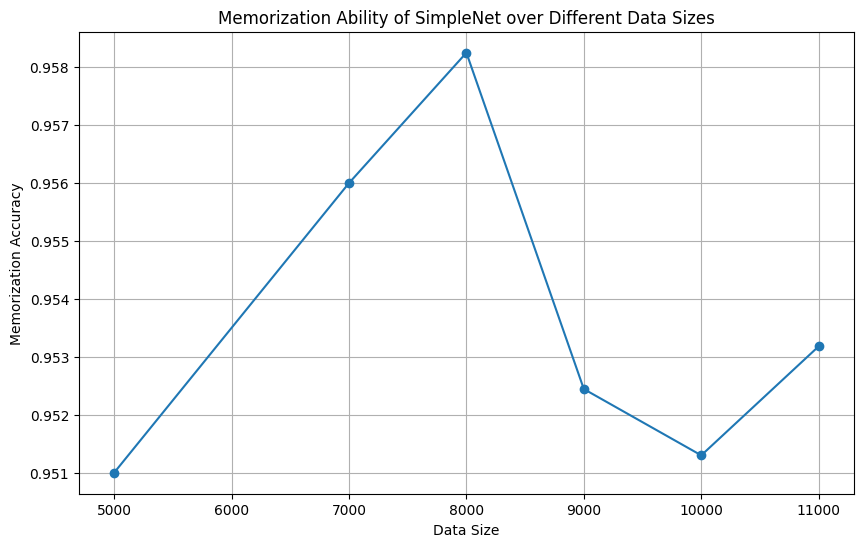

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the SimpleNet model
class SimpleNet(nn.Module):
    """
    A simple neural network with an added navigator layer.
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.navigator_layer = nn.Linear(128, 128)  # Navigator layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        x = self.navigator_layer(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate random images and labels
def generate_random_data(num_samples, img_size=(1, 28, 28), num_classes=10):
    images = torch.rand(num_samples, *img_size)  # Random images
    labels = torch.randint(0, num_classes, (num_samples,))  # Random labels
    return images, labels

# Custom dataset for random images
class RandomDataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Train and measure memorization
def train_and_evaluate(data_size, model, device, patience=5, min_delta=0.001, max_epochs=1000, min_epochs=100, accuracy_threshold=0.95):
    # Generate random training data for given size
    train_images, train_labels = generate_random_data(data_size, img_size, num_classes)
    train_images, train_labels = train_images.to(device), train_labels.to(device)
    train_dataset = RandomDataset(train_images, train_labels)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the model, loss function, and optimizer
    model = SimpleNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    previous_loss = float('inf')
    epochs_no_improve = 0
    memorization_accuracy = 0.0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        
        # Check for early stopping criteria
        if train_loss < previous_loss - min_delta:
            previous_loss = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Evaluate memorization accuracy on training data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        memorization_accuracy = correct / total

        # Check for stopping conditions
        if memorization_accuracy >= accuracy_threshold:
            print(f"Early stopping at epoch {epoch + 1} due to reaching memorization accuracy of {memorization_accuracy * 100:.2f}%")
            break

        if epoch + 1 >= min_epochs and epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to lack of improvement. Final loss: {train_loss:.4f}")
            break

    return memorization_accuracy

# Parameters
batch_size = 64
learning_rate = 0.0001
num_classes = 10
img_size = (1, 28, 28)  # Image size (1 channel, 28x28)
min_epochs = 200  # Minimum number of epochs to train
max_epochs = 1000  # Maximum number of epochs to train
patience = 50  # Patience for early stopping
min_delta = 0.0001  # Minimum change in loss to reset patience
accuracy_threshold = 0.95  # Memorization accuracy threshold to stop early

# Data sizes to test
data_sizes = [5000, 7000, 8000, 9000, 10000, 11000]
memorization_accuracies = []

# Train and evaluate the model for each data size
for data_size in data_sizes:
    print(f"Training with data size: {data_size}")
    accuracy = train_and_evaluate(
        data_size, 
        SimpleNet, 
        device, 
        patience=patience, 
        min_delta=min_delta, 
        max_epochs=max_epochs, 
        min_epochs=min_epochs, 
        accuracy_threshold=accuracy_threshold
    )
    memorization_accuracies.append(accuracy)
    print(f"Memorization Accuracy for data size {data_size}: {accuracy * 100:.2f}%")

# Plot the memorization ability over different data sizes
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, memorization_accuracies, marker='o', linestyle='-')
plt.xlabel('Data Size')
plt.ylabel('Memorization Accuracy')
plt.title('Memorization Ability of SimpleNet over Different Data Sizes')
plt.grid(True)
plt.show()


Using device: cuda
Training with data size: 20000
Early stopping at epoch 121 due to reaching memorization accuracy of 96.56%
Training with data size: 30000
Early stopping at epoch 129 due to reaching memorization accuracy of 96.59%
Training with data size: 40000
Early stopping at epoch 100 due to lack of improvement. Final loss: 2.3037 memorization accuracy of 9.75%
Training with data size: 45000
Early stopping at epoch 100 due to lack of improvement. Final loss: 2.3035 memorization accuracy of 9.94%
Training with data size: 50000
Early stopping at epoch 100 due to lack of improvement. Final loss: 2.3035 memorization accuracy of 10.00%

Memorization Results Table:
+-------------+------------------+-----------------------+-----------------------------+
|   Data Size |   Epochs Trained |   Final Training Loss |   Memorization Accuracy (%) |
+=============+==================+=======================+=============================+
|       20000 |              121 |              0.180199 | 

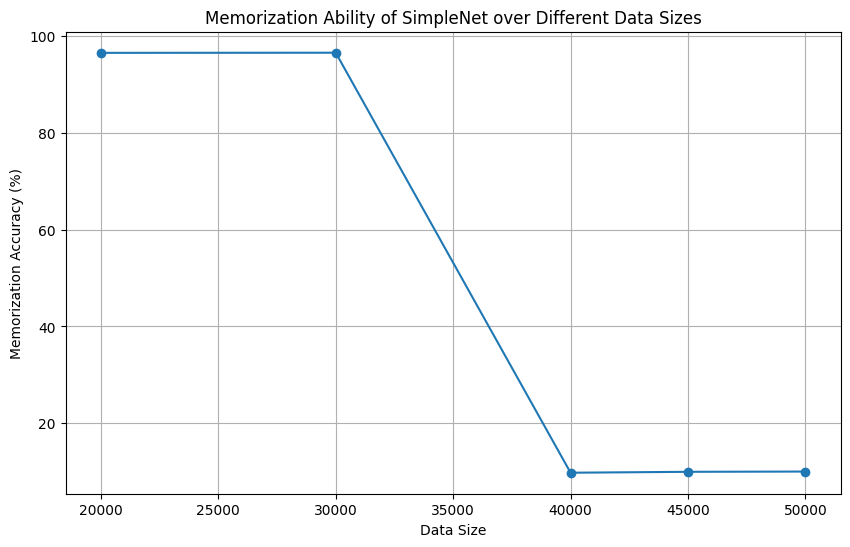

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from tabulate import tabulate

# Create directory for saving states if it doesn't exist
save_dir = "./saved_states"
os.makedirs(save_dir, exist_ok=True)

# Define the SimpleNet model based on your configuration
class SimpleNet(nn.Module):
    """
    A simple neural network with configurable navigator layers and randomized layers.
    """
    def __init__(self, num_navigator_layers=3, num_random_layers=1, random_layer_size=128):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Add configurable navigator layers
        self.navigator_layers = nn.ModuleList()
        for _ in range(num_navigator_layers):
            nav_layer = nn.Linear(128, 128)
            self.navigator_layers.append(nav_layer)
            self.navigator_layers.append(nn.ReLU())
        
        # Add configurable random layers
        self.random_layers = nn.ModuleList()
        for _ in range(num_random_layers):
            rand_layer = nn.Linear(random_layer_size, random_layer_size)
            # Initialize with random weights and biases
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            # Freeze the random layers
            for param in rand_layer.parameters():
                param.requires_grad = False
            self.random_layers.append(rand_layer)
            self.random_layers.append(nn.ReLU())
        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        
        # Pass through navigator layers
        for layer in self.navigator_layers:
            x = layer(x)
        
        # Pass through random layers if any
        for layer in self.random_layers:
            x = layer(x)
        
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate random images and labels
def generate_random_data(num_samples, img_size=(1, 28, 28), num_classes=10):
    images = torch.rand(num_samples, *img_size)  # Random images
    labels = torch.randint(0, num_classes, (num_samples,))  # Random labels
    return images, labels

# Custom dataset for random images
class RandomDataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Train and measure memorization
def train_and_evaluate(data_size, model, device, patience=5, min_delta=0.001, max_epochs=1000, min_epochs=100, accuracy_threshold=0.95):
    # Generate random training data for given size
    train_images, train_labels = generate_random_data(data_size, img_size, num_classes)
    train_images, train_labels = train_images.to(device), train_labels.to(device)
    train_dataset = RandomDataset(train_images, train_labels)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the model, loss function, and optimizer
    model = SimpleNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    previous_loss = float('inf')
    epochs_no_improve = 0
    memorization_accuracy = 0.0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        
        # Check for early stopping criteria
        if train_loss < previous_loss - min_delta:
            previous_loss = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Evaluate memorization accuracy on training data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        memorization_accuracy = correct / total

        # Check for stopping conditions
        if memorization_accuracy >= accuracy_threshold:
            print(f"Early stopping at epoch {epoch + 1} due to reaching memorization accuracy of {memorization_accuracy * 100:.2f}%")
            break

        if epoch + 1 >= min_epochs and epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to lack of improvement. Final loss: {train_loss:.4f} memorization accuracy of {memorization_accuracy * 100:.2f}%")
            break

    return memorization_accuracy, epoch + 1, train_loss

# Parameters
batch_size = 512
learning_rate = 0.001
num_classes = 10
img_size = (1, 28, 28)  # Image size (1 channel, 28x28)
min_epochs = 100  # Minimum number of epochs to train
max_epochs = 1000  # Maximum number of epochs to train
patience = 10  # Patience for early stopping
min_delta = 0.0001  # Minimum change in loss to reset patience
accuracy_threshold = 0.95  # Memorization accuracy threshold to stop early

# Data sizes to test
data_sizes = [20000, 30000, 40000, 45000, 50000]
results = []

# Train and evaluate the model for each data size
for data_size in data_sizes:
    print(f"Training with data size: {data_size}")
    accuracy, epochs_trained, final_loss = train_and_evaluate(
        data_size, 
        SimpleNet, 
        device, 
        patience=patience, 
        min_delta=min_delta, 
        max_epochs=max_epochs, 
        min_epochs=min_epochs, 
        accuracy_threshold=accuracy_threshold
    )
    results.append([data_size, epochs_trained, final_loss, accuracy * 100])

# Display results as a table
headers = ["Data Size", "Epochs Trained", "Final Training Loss", "Memorization Accuracy (%)"]
print("\nMemorization Results Table:")
print(tabulate(results, headers=headers, tablefmt="grid"))

# Plot the memorization ability over different data sizes
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, [res[3] for res in results], marker='o', linestyle='-')
plt.xlabel('Data Size')
plt.ylabel('Memorization Accuracy (%)')
plt.title('Memorization Ability of SimpleNet over Different Data Sizes')
plt.grid(True)
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 512
subset_size = 5000  # Fixed number of examples per dataset
save_dir = "./saved_states"  # Directory to save the model and optimizer states
os.makedirs(save_dir, exist_ok=True)

# Hyperparameters for experiments
learning_rate_adam = 0.001  # Learning rate for ADAM optimizers
learning_rate_sgd = 0.000001    # Learning rate for SGD optimizer (Navigator)
num_iterations = 100        # Number of iterations

# ===========================
# 1.a. Configurable Parameters
# ===========================

# Configuration for Random Layers
num_random_layers = 1       # Number of randomized layers to add
random_layer_size = 128     # Size (number of neurons) of each randomized layer

# Configuration for Navigator Layers
num_navigator_layers = 1    # Number of navigator layers to add

# Flag to re-randomize the random layers during task switching
re_randomize = False         # Set to True to re-randomize, False to keep them fixed

# Cosine Similarity Regularization Parameters
enable_cosine_similarity = True  # Flag to enable/disable cosine similarity training
similarity_weight = 0.005         # Weight for the cosine similarity loss
ema_momentum = 0.3                # Momentum for updating reference parameters

# Randomization factor configuration
max_randomization = 0.00001  # Maximum randomization factor (e.g., 1.0 for full randomization)

# Training Epochs
num_epochs_train = 1       # Number of epochs for regular training
num_epochs_navigator = 1    # Number of epochs for navigator training

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A neural network with configurable navigator layers, randomized layers, and additional complexity in the main training layers.
    """
    def __init__(self, num_navigator_layers=1, num_random_layers=1, random_layer_size=128, main_layer_sizes=[128, 256, 128, 10]):
        super(SimpleNet, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Add configurable navigator layers
        self.navigator_layers = nn.ModuleList()
        for _ in range(num_navigator_layers):
            self.navigator_layers.append(nn.Linear(128, 128))
            self.navigator_layers.append(nn.ReLU())
        
        # Add configurable random layers
        self.random_layers = nn.ModuleList()
        for _ in range(num_random_layers):
            rand_layer = nn.Linear(random_layer_size, random_layer_size)
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            # Freeze the random layers
            for param in rand_layer.parameters():
                param.requires_grad = False
            self.random_layers.append(rand_layer)
            self.random_layers.append(nn.ReLU())

        # Add increased complexity in the training layers
        self.main_layers = nn.ModuleList()
        for i in range(len(main_layer_sizes) - 1):
            self.main_layers.append(nn.Linear(main_layer_sizes[i], main_layer_sizes[i + 1]))
            if i < len(main_layer_sizes) - 2:  # No activation after the final output layer
                self.main_layers.append(nn.ReLU())
        
        # Initialize randomization factor
        self.randomization_factor = 0.0  # Will be updated during training

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        
        # Pass through navigator layers
        for layer in self.navigator_layers:
            x = layer(x)
        
        # Save output before random layers
        x_pre_random = x.clone()
        
        # Pass through random layers
        for layer in self.random_layers:
            x = layer(x)
        
        # Combine with randomization factor
        x = (1 - self.randomization_factor) * x_pre_random + self.randomization_factor * x
        
        # Pass through the new main training layers
        for layer in self.main_layers:
            x = layer(x)
        
        return x

# ===========================
# 3. Helper Classes and Functions
# ===========================

class RandomDataset(torch.utils.data.Dataset):
    """
    Custom dataset for random images and labels.
    """
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def generate_random_data_A(num_samples, img_size=(1, 28, 28), num_classes=10):
    """
    Generates random images and labels for Dataset A using uniform distribution.
    """
    images = torch.rand(num_samples, *img_size)  # Uniformly random images
    labels = torch.randint(0, num_classes, (num_samples,))  # Random labels
    return images, labels

def generate_random_data_B(num_samples, img_size=(1, 28, 28), num_classes=10):
    """
    Generates random images and labels for Dataset B using normal distribution and scaling.
    """
    images = torch.randn(num_samples, *img_size) * 0.5 + 0.5  # Normally distributed images scaled to [0,1]
    images = torch.clamp(images, 0, 1)  # Ensure pixel values are in [0,1]
    labels = torch.randint(0, num_classes, (num_samples,))  # Random labels
    return images, labels

def get_random_subset(dataset, fraction):
    """
    Returns a random subset of the dataset corresponding to the given fraction.
    """
    subset_size = int(len(dataset) * fraction)
    indices = np.random.choice(len(dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

def compute_cosine_similarity(params_A, params_B):
    """
    Computes the cosine similarity between two sets of parameters.
    """
    # Flatten and concatenate all parameters for A and B
    params_A_vector = torch.cat([param.view(-1) for param in params_A]).to(device)
    params_B_vector = torch.cat([param.view(-1) for param in params_B]).to(device)
    
    # Compute cosine similarity
    cos_sim = F.cosine_similarity(params_A_vector, params_B_vector, dim=0)
    return cos_sim.item()

def get_flattened_gradients(params_to_include):
    """
    Extracts and flattens all gradients from the specified parameters into a single vector.
    """
    grads = []
    for param in params_to_include:
        if param.grad is not None:
            grads.append(param.grad.view(-1))
    if not grads:
        return torch.zeros(1).to(device)
    return torch.cat(grads)

def reinitialize_random_layers(model):
    """
    Reinitializes the weights and biases of the randomized layers.
    """
    for layer in model.random_layers:
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight)
            nn.init.normal_(layer.bias)

def evaluate_memorization(model, train_loader, device):
    """
    Evaluates the memorization accuracy on the training data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total) * 100  # Convert to percentage

def train_model(model, train_loader, optimizer, criterion, num_epochs, device, 
               collect_gradients=False, params_to_include=None, 
               reference_parameters=None, similarity_weight=0.0):
    """
    Trains the model and records training loss per epoch and per step.
    Optionally collects and returns the flattened gradient vector.
    Optionally includes a cosine similarity loss to align parameters with reference_parameters.
    Returns a tuple of (epoch_losses, step_losses, gradient_vector or None).
    """
    model.train()
    epoch_losses = []
    step_losses = []
    gradient_vector = None
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Fixed: labels -> targets
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # If reference_parameters and similarity_weight are provided, compute cosine similarity loss
            if enable_cosine_similarity and reference_parameters is not None and similarity_weight > 0.0:
                # Compute cosine similarity between current parameters and reference parameters
                current_params = [param for param in model.parameters() if param.requires_grad]
                cos_sim = compute_cosine_similarity(reference_parameters, current_params)
                similarity_loss = similarity_weight * (1 - cos_sim)  # We want to maximize cos_sim
                loss = loss + similarity_loss
            
            loss.backward()
            
            if collect_gradients and params_to_include is not None:
                gradient_vector = get_flattened_gradients(params_to_include).detach().clone()
            
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            step_losses.append(loss.item())
        
        epoch_loss /= len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
    return epoch_losses, step_losses, gradient_vector

# ===========================
# 4. Main Execution Loop
# ===========================

def main():
    global inference_losses_A, inference_losses_B, individual_losses_A, individual_losses_B, individual_losses_navigator
    global grad_cosine_similarities, weight_cosine_similarities, training_steps, training_phases
    # Initialize all lists as global to be accessible in main_with_visualizations
    inference_losses_A = []
    inference_losses_B = []
    individual_losses_A = []
    individual_losses_B = []
    individual_losses_navigator = []
    grad_cosine_similarities = []
    weight_cosine_similarities = []
    training_steps = []
    training_phases = []
    
    step_counter = 1  # To index training steps for plotting
    
    # Generate two separate random datasets: Dataset A and Dataset B using different methods
    print("\n=== Generating Random Datasets ===")
    images_A, labels_A = generate_random_data_A(subset_size)
    images_B, labels_B = generate_random_data_B(subset_size)
    
    # Create DataLoaders for both datasets
    dataset_A = RandomDataset(images_A, labels_A)
    dataset_B = RandomDataset(images_B, labels_B)
    
    train_loader_A = torch.utils.data.DataLoader(dataset_A, batch_size=batch_size, shuffle=True)
    test_loader_A = torch.utils.data.DataLoader(dataset_A, batch_size=batch_size, shuffle=False)  # Using training data as test for memorization
    
    train_loader_B = torch.utils.data.DataLoader(dataset_B, batch_size=batch_size, shuffle=True)
    test_loader_B = torch.utils.data.DataLoader(dataset_B, batch_size=batch_size, shuffle=False)  # Using training data as test for memorization
    
    # Initialize model with the configured number of navigator and random layers
    model = SimpleNet(
        num_navigator_layers=num_navigator_layers, 
        num_random_layers=num_random_layers, 
        random_layer_size=random_layer_size, 
        main_layer_sizes=[128, 256, 128, 10]  # Increased complexity
    ).to(device)
    
    # Define the criterion
    criterion = nn.CrossEntropyLoss()
    
    # Collect parameters
    # Exclude random layers from trainable parameters
    params_main = [param for name, param in model.named_parameters() 
                  if 'navigator_layers' not in name and 'random_layers' not in name]
    params_navigator = [param for name, param in model.named_parameters() 
                        if 'navigator_layers' in name]
    
    # Store initial parameters for cosine similarity
    initial_params_main = [param.detach().clone() for param in params_main]
    
    # Initialize reference parameters as a deep copy of the initial parameters
    if enable_cosine_similarity:
        reference_parameters = [param.detach().clone() for param in params_main]
    else:
        reference_parameters = None  # No reference parameters needed if cosine similarity is disabled
    
    # Initialize lists to store parameters after A and B for cosine similarity
    params_after_A = []
    params_after_B = []
    
    # ===========================
    # 4.b. Iterative Training Loop
    # ===========================
    
    print("\n=== Starting Iterative Training Loop ===")
    for iteration in range(num_iterations):
        # Compute randomization factor
        if num_iterations > 1:
            randomization_factor = (iteration / (num_iterations - 1)) * max_randomization
        else:
            randomization_factor = max_randomization
        model.randomization_factor = randomization_factor
        print(f"\n--- Iteration {iteration + 1}/{num_iterations}, Randomization Factor: {randomization_factor:.4f} ---")
        
        # ==============================
        # Phase 1: Train on Dataset A
        # ==============================
        print("Phase 1: Training on Dataset A")
        # Freeze navigator layers
        for param in params_navigator:
            param.requires_grad = False
        # Unfreeze training layers
        for param in params_main:
            param.requires_grad = True
        # Create optimizer for training layers (Adam)
        optimizer_A = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate_adam)
        
        epoch_loss_A, step_loss_A, grad_A = train_model(
            model, 
            train_loader_A, 
            optimizer_A, 
            criterion, 
            num_epochs_train, 
            device, 
            collect_gradients=True, 
            params_to_include=params_main,
            reference_parameters=reference_parameters if enable_cosine_similarity else None,
            similarity_weight=similarity_weight if enable_cosine_similarity else 0.0
        )
        
        # Store the individual training loss for Dataset A
        individual_losses_A.extend(step_loss_A)
        
        # Store parameters after training on A
        params_A = [param.detach().clone() for param in params_main]
        params_after_A.append(params_A)
        
        # Compute cosine similarity between initial parameters and after training on A
        if enable_cosine_similarity:
            cos_sim_initial_A = compute_cosine_similarity(initial_params_main, params_A)
            print(f"Cosine Similarity between Initial Parameters and After Training on A: {cos_sim_initial_A:.4f}")
        else:
            cos_sim_initial_A = None
        
        # Evaluate memorization accuracy after training on A
        mem_acc_A = evaluate_memorization(model, test_loader_A, device)
        mem_acc_B = evaluate_memorization(model, test_loader_B, device)
        inference_losses_A.append(mem_acc_A)
        inference_losses_B.append(mem_acc_B)
        print(f"After Training on A - Memorization Accuracy: Dataset A: {mem_acc_A:.2f}%, Dataset B: {mem_acc_B:.2f}%")
        training_steps.append(step_counter)
        training_phases.append('Train_A')
        step_counter += 1
        
        # ==============================
        # Phase 2: Navigator Training A -> B
        # ==============================
        print("Phase 2: Navigator Training from A to B")
        # Freeze training layers
        for param in params_main:
            param.requires_grad = False
        # Unfreeze navigator layers
        for param in params_navigator:
            param.requires_grad = True
        # Create optimizer for navigator layers (SGD)
        optimizer_nav = optim.SGD(params_navigator, lr=learning_rate_sgd)
        
        # Optional: Re-randomize the random layers if the flag is set
        if re_randomize:
            reinitialize_random_layers(model)
            print("Randomized layers reinitialized.")
        
        # Train on a random 5% subset of Dataset B for Navigator
        subset_B = get_random_subset(train_loader_B.dataset, fraction=0.05)  # 5% of 1000 = 50 samples
        loader_B_subset = torch.utils.data.DataLoader(subset_B, batch_size=1, shuffle=True)
        epoch_loss_nav, step_loss_nav, _ = train_model(
            model, 
            loader_B_subset, 
            optimizer_nav, 
            criterion, 
            num_epochs_navigator, 
            device, 
            collect_gradients=False,
            params_to_include=None,  # No gradient collection during Navigator training
            reference_parameters=None,  # No similarity loss during Navigator training
            similarity_weight=0.0
        )
        
        # Store the individual training loss for Navigator
        individual_losses_navigator.extend(step_loss_nav)
        
        # Evaluate memorization accuracy after Navigator training A -> B
        mem_acc_A = evaluate_memorization(model, test_loader_A, device)
        mem_acc_B = evaluate_memorization(model, test_loader_B, device)
        inference_losses_A.append(mem_acc_A)
        inference_losses_B.append(mem_acc_B)
        print(f"After Navigating A -> B - Memorization Accuracy: Dataset A: {mem_acc_A:.2f}%, Dataset B: {mem_acc_B:.2f}%")
        training_steps.append(step_counter)
        training_phases.append('Navigator_A->B')
        step_counter += 1
        
        # ==============================
        # Phase 3: Train on Dataset B
        # ==============================
        print("Phase 3: Training on Dataset B")
        # Freeze navigator layers
        for param in params_navigator:
            param.requires_grad = False
        # Unfreeze training layers
        for param in params_main:
            param.requires_grad = True
        # Create optimizer for training layers (Adam)
        optimizer_B = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate_adam)
        
        epoch_loss_B, step_loss_B, grad_B = train_model(
            model, 
            train_loader_B, 
            optimizer_B, 
            criterion, 
            num_epochs_train, 
            device, 
            collect_gradients=True, 
            params_to_include=params_main,
            reference_parameters=reference_parameters if enable_cosine_similarity else None,
            similarity_weight=similarity_weight if enable_cosine_similarity else 0.0
        )
        
        # Store the individual training loss for Dataset B
        individual_losses_B.extend(step_loss_B)
        
        # Store parameters after training on B
        params_B = [param.detach().clone() for param in params_main]
        params_after_B.append(params_B)
        
        # Compute cosine similarity between parameters after A and B training
        if enable_cosine_similarity:
            cos_sim_A_B = compute_cosine_similarity(params_after_A[iteration], params_B)
            print(f"Cosine Similarity between Parameters after Training on A and B: {cos_sim_A_B:.4f}")
        else:
            cos_sim_A_B = None
        
        # Evaluate memorization accuracy after training on B
        mem_acc_A = evaluate_memorization(model, test_loader_A, device)
        mem_acc_B = evaluate_memorization(model, test_loader_B, device)
        inference_losses_A.append(mem_acc_A)
        inference_losses_B.append(mem_acc_B)
        print(f"After Training on B - Memorization Accuracy: Dataset A: {mem_acc_A:.2f}%, Dataset B: {mem_acc_B:.2f}%")
        training_steps.append(step_counter)
        training_phases.append('Train_B')
        step_counter += 1
        
        # ==============================
        # Phase 4: Navigator Training B -> A
        # ==============================
        print("Phase 4: Navigator Training from B -> A")
        # Freeze training layers
        for param in params_main:
            param.requires_grad = False
        # Unfreeze navigator layers
        for param in params_navigator:
            param.requires_grad = True
        # Create optimizer for navigator layers (SGD)
        optimizer_nav = optim.SGD(params_navigator, lr=learning_rate_sgd)
        
        # Optional: Re-randomize the random layers if the flag is set
        if re_randomize:
            reinitialize_random_layers(model)
            print("Randomized layers reinitialized.")
        
        # Train on a random 5% subset of Dataset A for Navigator
        subset_A = get_random_subset(train_loader_A.dataset, fraction=0.05)  # 5% of 1000 = 50 samples
        loader_A_subset = torch.utils.data.DataLoader(subset_A, batch_size=1, shuffle=True)
        epoch_loss_nav_A, step_loss_nav_A, _ = train_model(
            model, 
            loader_A_subset, 
            optimizer_nav, 
            criterion, 
            num_epochs_navigator, 
            device, 
            collect_gradients=False,
            params_to_include=None,  # No gradient collection during Navigator training
            reference_parameters=None,  # No similarity loss during Navigator training
            similarity_weight=0.0
        )
        
        # Store the individual training loss for Navigator on A
        individual_losses_navigator.extend(step_loss_nav_A)
        
        # Evaluate memorization accuracy after Navigator training B -> A
        mem_acc_A = evaluate_memorization(model, test_loader_A, device)
        mem_acc_B = evaluate_memorization(model, test_loader_B, device)
        inference_losses_A.append(mem_acc_A)
        inference_losses_B.append(mem_acc_B)
        print(f"After Navigating B -> A - Memorization Accuracy: Dataset A: {mem_acc_A:.2f}%, Dataset B: {mem_acc_B:.2f}%")
        training_steps.append(step_counter)
        training_phases.append('Navigator_B->A')
        step_counter += 1
        
        # ==============================
        # Phase 5: Cosine Similarity Summary
        # ==============================
        if enable_cosine_similarity:
            print(f"--- Iteration {iteration + 1} Summary ---")
            print(f"Cosine Similarity between Initial Parameters and After Training on A: {cos_sim_initial_A:.4f}")
            print(f"Cosine Similarity between Parameters after Training on A and B: {cos_sim_A_B:.4f}")
            grad_cosine_similarities.append(cos_sim_A_B)
            print("----------------------------------------")
        else:
            print(f"--- Iteration {iteration + 1} Summary ---")
            print("Cosine Similarity Disabled")
            print("----------------------------------------")
        
        # ==============================
        # Phase 6: Update Reference Parameters using EMA (Optional)
        # ==============================
        if enable_cosine_similarity:
            print("Phase 6: Updating Reference Parameters using EMA")
            for ref, param in zip(reference_parameters, params_main):
                ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
        else:
            print("Phase 6: Reference Parameters Update Skipped (Cosine Similarity Disabled)")
        
        # Record cosine similarity
        if enable_cosine_similarity:
            weight_cosine_similarities.append(cos_sim_A_B)
        else:
            weight_cosine_similarities.append(None)

# ===========================
# 5. Execute Main Function with Visualizations
# ===========================

def main_with_visualizations():
    main()  # Execute the main training loop

    # Since subset_size is fixed at 1000, we create a single entry for results
    if inference_losses_A and inference_losses_B:
        results = [[subset_size, inference_losses_A[-1], inference_losses_B[-1]]]
    else:
        results = [["N/A", "N/A", "N/A"]]

    # Print the memorization accuracies as a table
    headers = ["Data Size", "Memorization Accuracy A (%)", "Memorization Accuracy B (%)"]
    print("\nMemorization Results Table:")
    print(tabulate(results, headers=headers, tablefmt="grid"))
    
    # ===========================
    # 6. Visualization (at the end of all iterations)
    # ===========================

    # 1. Three Individual Loss Plots (1x3 Subplot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Dataset A Training Loss
    if individual_losses_A:
        axes[0].plot(range(1, len(individual_losses_A) + 1), individual_losses_A, color='blue', label='Dataset A')
        axes[0].set_title('Dataset A (Uniform) Training Loss')
        axes[0].set_xlabel('Training Step')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True)
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
        axes[0].set_title('Dataset A (Uniform) Training Loss')
        axes[0].set_xlabel('Training Step')
        axes[0].set_ylabel('Loss')
    
    # Dataset B Training Loss
    if individual_losses_B:
        axes[1].plot(range(1, len(individual_losses_B) + 1), individual_losses_B, color='red', label='Dataset B')
        axes[1].set_title('Dataset B (Normal) Training Loss')
        axes[1].set_xlabel('Training Step')
        axes[1].set_ylabel('Loss')
        axes[1].grid(True)
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
        axes[1].set_title('Dataset B (Normal) Training Loss')
        axes[1].set_xlabel('Training Step')
        axes[1].set_ylabel('Loss')
    
    # Navigator Layer Training Loss
    if individual_losses_navigator:
        axes[2].plot(range(1, len(individual_losses_navigator) + 1), individual_losses_navigator, color='green', label='Navigator Layer')
        axes[2].set_title('Navigator Layer Training Loss')
        axes[2].set_xlabel('Training Step')
        axes[2].set_ylabel('Loss')
        axes[2].grid(True)
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
        axes[2].set_title('Navigator Layer Training Loss')
        axes[2].set_xlabel('Training Step')
        axes[2].set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Cumulative Memorization Accuracy Plot
    if training_steps and inference_losses_A and inference_losses_B:
        plt.figure(figsize=(12, 6))
        plt.plot(training_steps, inference_losses_A, label='Dataset A Memorization Accuracy', marker='o', color='blue')
        plt.plot(training_steps, inference_losses_B, label='Dataset B Memorization Accuracy', marker='x', color='red')
        
        # Highlight Navigator Training Steps
        for idx, phase in enumerate(training_phases):
            if 'Navigator' in phase:
                plt.axvspan(training_steps[idx]-0.5, training_steps[idx]+0.5, color='yellow', alpha=0.1)
        
        plt.xlabel('Training Step')
        plt.ylabel('Memorization Accuracy (%)')
        plt.title('Memorization Accuracy on Both Datasets Over Training Steps')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Insufficient data for memorization accuracy plot.")
    
    # 3. Cosine Similarity Plot
    if grad_cosine_similarities:
        plt.figure(figsize=(12, 6))
        iterations = range(1, len(grad_cosine_similarities) + 1)
        plt.plot(iterations, grad_cosine_similarities, label='Cosine Similarity (A vs B)', marker='s', color='purple')
        plt.xlabel('Iteration')
        plt.ylabel('Cosine Similarity')
        plt.title('Cosine Similarity Between Parameters After Training on A and B')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No cosine similarity data to plot.")

if __name__ == "__main__":
    main_with_visualizations()
